In [14]:
%matplotlib inline

import itertools
from tqdm import tqdm
from tqdm import trange
from functools import partial
from multiprocessing import Pool, cpu_count
import numpy as np
# np.seterr(all='ignore')
import scipy.special as special
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.interpolate as interpolate
from scipy.stats import rv_continuous, poisson, uniform, norm, chi2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 4.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.weight'] = 'bold'

Ncpu = 100

In [2]:
def glow(n, tau):
    return np.random.exponential(tau, size=n)

def transit(n, sigma):
    return np.random.normal(0, sigma, size=n)

def time(n, tau, sigma):
    if tau == 0:
        return np.sort(transit(n, sigma))
    elif sigma == 0:
        return np.sort(glow(n, tau))
    else:
        return np.sort(glow(n, tau) + transit(n, sigma))

def convolve_exp_norm(x, tau, sigma):
    if sigma == 0.:
        y = np.where(x >= 0., 1/tau * np.exp(-x/tau), 0.)
    elif tau == 0.:
        y = norm.pdf(x, loc=0, scale=sigma)
    else:
        alpha = 1/tau
        co = alpha/2. * np.exp(alpha*alpha*sigma*sigma/2.)
        x_erf = (alpha*sigma*sigma - x)/(np.sqrt(2.)*sigma)
        y = co * np.exp(-alpha*x) * (1. - special.erf(x_erf))
    return y

def start_time(a0, a1, mu, tau, sigma):
    np.random.seed(a0)
    stime = np.zeros(a1 - a0)
    samples = [time(n, tau, sigma) for n in 
               poisson.ppf(1 - uniform.rvs(scale=1-poisson.cdf(0, mu), size=a1 - a0), mu).astype(np.int)]
    for i in range(a1 - a0):
        logL = lambda t0 : -1 * np.sum(np.log(np.clip(convolve_exp_norm(samples[i] - t0, tau, sigma), 
                                                      np.finfo(np.float).tiny, np.inf)))
        if sigma == 0.:
            stime[i] = optimize.minimize(logL, x0=np.min(samples[i]), method='BFGS')['x']
        else:
            stime[i] = optimize.minimize(logL, x0=np.min(samples[i])-1, method='L-BFGS-B', bounds=[[-np.inf, samples[i][0]]])['x']
    return stime, samples

def deltatime(mu, tau, sigma, N):
    chunk = N // Ncpu + 1
    slices = np.vstack((np.arange(0, N, chunk), np.append(np.arange(chunk, N, chunk), N))).T.astype(np.int).tolist()
    with Pool(min(Ncpu, cpu_count())) as pool:
        result = pool.starmap(partial(start_time, mu=mu, tau=tau, sigma=sigma), slices)

    stime = np.concatenate([result[i][0] for i in range(len(slices))])
    samples = list(itertools.chain.from_iterable([result[i][1] for i in range(len(slices))]))
        
    deltat = stime
    deltat0 = np.array([samples[i][0] for i in range(N)])
    std = np.std(deltat, ddof=-1)
    std0 = np.std(deltat0, ddof=-1)
    return deltat, deltat0, std, std0

In [3]:
N = int(1e4)

Mu = np.arange(2, 22, 2).astype(np.int)
Tau = np.arange(10, 40, 3).astype(np.int)
Sigma = np.arange(1, 11, 1).astype(np.int)
Deltaall = np.zeros((len(Mu), len(Tau), len(Sigma), N))
Delta1st = np.zeros((len(Mu), len(Tau), len(Sigma), N))
Stdall = np.zeros((len(Mu), len(Tau), len(Sigma)))
Std1st = np.zeros((len(Mu), len(Tau), len(Sigma)))

for m in trange(len(Mu), desc='   mu'):
    for t in trange(len(Tau), desc='  tau'):
#         for s in trange(len(Sigma), desc='sigma'):
        for s in range(len(Sigma)):
            mu = Mu[m]
            tau = Tau[t]
            sigma = Sigma[s]
            
            Deltaall[m, t, s], Delta1st[m, t, s], Stdall[m, t, s], Std1st[m , t, s] = deltatime(mu, tau, sigma, N)

            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_axes((.1, .1, .8, .8))
            ax.hist(Deltaall[m, t, s], bins=50, alpha=0.5, color='b', label='all PE')
            ax.hist(Delta1st[m, t, s], bins=50, alpha=0.5, color='r', label='1st PE')
            ax.set_xlabel(r'$\Delta t/\mathrm{ns}$')
            ax.set_ylabel(r'$Count$')
            ax.set_title(r'$\mu=${:.01f}'.format(mu) + r'$\mathrm{ns}\ $' + 
                         r'$\tau=${:.01f}'.format(tau) + r'$\mathrm{ns}\ $' + 
                         r'$\sigma=${:.01f}'.format(sigma) + r'$\mathrm{ns}\ $' + 
                         r'$\mathrm{N}=$' + '{0:.1E}\n'.format(N) + 
                         r'$\delta_{1st}-\delta_{all}=$' + 
                         r'{:.02f}$-${:.02f}$=${:.02f}'.format(Std1st[m , t, s], Stdall[m, t, s], Std1st[m , t, s] - Stdall[m, t, s]) + 
                         r'$\mathrm{ns}$')
            ax.ticklabel_format(style='sci', scilimits=(-2, 3))
            ax.legend()
            fig.savefig('img/vs/vs-{:02d}-{:02d}-{:02d}.png'.format(mu, tau, sigma))
            plt.close()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes((.1, .1, .8, .8))
ax.hist(Deltaall.flatten(), bins=50, alpha=0.5, color='b', label='all PE')
ax.hist(Delta1st.flatten(), bins=50, alpha=0.5, color='r', label='1st PE')
ax.set_xlabel(r'$\Delta t/\mathrm{ns}$')
ax.set_ylabel(r'$Count$')
ax.set_title(r'$\mathrm{N}=$' + '{:2d}\n'.format(N) + 
             r'$\delta_{1st}-\delta_{all}=$' + 
             r'{:.02f}$-${:.02f}$=${:.02f}'.format(np.std(Delta1st, ddof=-1), np.std(Deltaall, ddof=-1), np.std(Delta1st, ddof=-1) - np.std(Deltaall, ddof=-1)) + 
             r'$\mathrm{ns}$')
ax.ticklabel_format(style='sci', scilimits=(-2, 3))
ax.legend()
fig.savefig('img/vs/vs.png')
plt.close()

   mu: 100%|██████████| 10/10 [1:52:21<00:00, 674.16s/it]


In [4]:
para = {'ideal' : {'tau' : 20., 'sigma' : 0.}, 
        'JNE' : {'tau' : 20., 'sigma' : 1.5}, 
        'JUNO' : {'tau' : 20., 'sigma' : 6.}, 
        'SK' : {'tau' : 0., 'sigma' : 3.}, 
        'slow' : {'tau' : 40., 'sigma' : 2.}, 
        'fast' : {'tau' : 10, 'sigma' : 2.}}

N = int(1e5)
Mu = np.linspace(2, 22, num=101)
result = {}

for key in para.keys():
    tau = para[key]['tau']
    sigma = para[key]['sigma']
    Deltaall = np.zeros((len(Mu), N))
    Delta1st = np.zeros((len(Mu), N))
    Stdall = np.zeros(len(Mu))
    Std1st = np.zeros(len(Mu))
    for m in trange(len(Mu), desc=key.ljust(6, ' ')):
        mu = Mu[m]
        Deltaall[m], Delta1st[m], Stdall[m], Std1st[m] = deltatime(mu, tau, sigma, N)
    result.update({key : {'Deltaall' : Deltaall, 'Delta1st' : Delta1st, 'Stdall' : Stdall, 'Std1st' : Std1st}})

fast  : 100%|██████████| 101/101 [24:13<00:00, 14.40s/it]


In [15]:
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.5)

alpha = 0.95
keys = list(para.keys())
for k in range(len(keys)):
    key = keys[k]
    ax = fig.add_subplot(gs[k])
    yerr1st = np.vstack([result[key]['Std1st']-np.sqrt(np.power(result[key]['Std1st'],2)*N/chi2.ppf(1-alpha/2, N)), np.sqrt(np.power(result[key]['Std1st'],2)*N/chi2.ppf(alpha/2, N))-result[key]['Std1st']])
    yerrall = np.vstack([result[key]['Stdall']-np.sqrt(np.power(result[key]['Stdall'],2)*N/chi2.ppf(1-alpha/2, N)), np.sqrt(np.power(result[key]['Stdall'],2)*N/chi2.ppf(alpha/2, N))-result[key]['Stdall']])
    ax.errorbar(Mu, result[key]['Std1st'], yerr=yerr1st, color='b', label='1st PE', marker='^')
    ax.errorbar(Mu, result[key]['Stdall'], yerr=yerrall, color='r', label='all PE', marker='^')
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\delta/\mathrm{ns}$')
    ax.set_title(r'{} '.format(key) + r'$\tau=${:.01f}'.format(para[key]['tau']) + r'$\mathrm{ns}\ $' + 
                 r'$\sigma=${:.01f}'.format(para[key]['sigma']) + r'$\mathrm{ns}\ $' + 
                 r'$\mathrm{N}=$' + '{0:.1E}\n'.format(N))
    ax.grid()
    ax.legend()
fig.savefig('img/vs/vs-delta.png')
plt.close()
    
fig = plt.figure(figsize=(24, 16))
gs = gridspec.GridSpec(3, 2, figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.5)

keys = list(para.keys())
for k in range(len(keys)):
    key = keys[k]
    ax = fig.add_subplot(gs[k])
    yerr1st = np.vstack([result[key]['Std1st']-np.sqrt(np.power(result[key]['Std1st'],2)*N/chi2.ppf(1-alpha/2, N)), np.sqrt(np.power(result[key]['Std1st'],2)*N/chi2.ppf(alpha/2, N))-result[key]['Std1st']])
    yerrall = np.vstack([result[key]['Stdall']-np.sqrt(np.power(result[key]['Stdall'],2)*N/chi2.ppf(1-alpha/2, N)), np.sqrt(np.power(result[key]['Stdall'],2)*N/chi2.ppf(alpha/2, N))-result[key]['Stdall']])
    yerr = np.vstack([yerr1st[0] - yerrall[1], yerr1st[1] - yerrall[0]])
    ax.errorbar(Mu, result[key]['Std1st'] - result[key]['Stdall'], yerr=yerr, color='b', label=r'$\delta_{1st}-\delta_{all}$', marker='^')
    ax.hlines(0, xmin=Mu[0], xmax=Mu[-1], color='k', label='0')
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\delta_{1st}-\delta_{all}/\mathrm{ns}$')
    ax.set_title(r'{} '.format(key) + r'$\tau=${:.01f}'.format(para[key]['tau']) + r'$\mathrm{ns}\ $' + 
                 r'$\sigma=${:.01f}'.format(para[key]['sigma']) + r'$\mathrm{ns}\ $' + 
                 r'$\mathrm{N}=$' + '{0:.1E}\n'.format(N))
    ax.grid()
    ax.legend()
fig.savefig('img/vs/vs-deltasub.png')
plt.close()

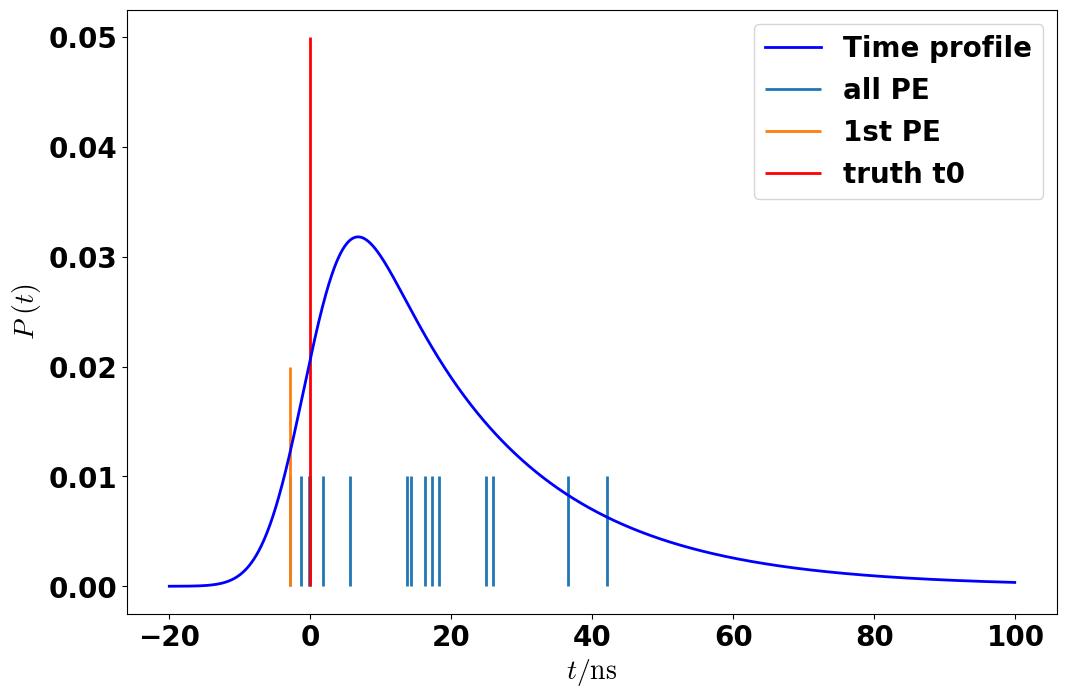

In [9]:
np.random.seed(3)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
tau = 20
sigma = 5
t = np.arange(-20, 100, 0.1)
ax.plot(t, convolve_exp_norm(t, tau, sigma), color='b', label='Time profile')
smaples = time(15, tau, sigma)
ax.vlines(smaples, ymin=0, ymax=0.01, color='C0', label='all PE')
ax.vlines(smaples.min(), ymin=0, ymax=0.02, color='C1', label='1st PE')
ax.vlines(0, ymin=0, ymax=0.05, color='r', label='truth t0')
ax.set_xlabel(r'$t/\mathrm{ns}$')
ax.set_ylabel(r'$P~(t)$')
ax.legend()
fig.savefig('img/vs/vs-demo.png')